# Tiny nerf in PyTorch

Rewrite of the [tiny nerf notebook](https://github.com/bmild/nerf/blob/master/tiny_nerf.ipynb) from TensorFlow to PyTorch.

H=100, W=100


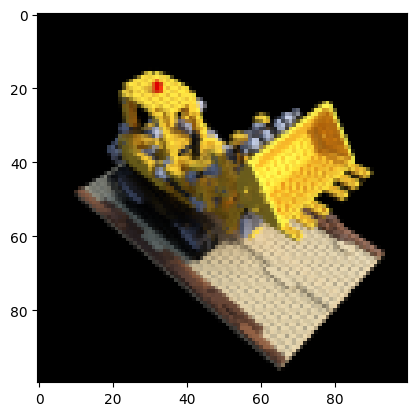

In [5]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

data = np.load("../data/tiny_nerf_data.npz")
imgs, poses, focal = data["images"], data["poses"], data["focal"]
_, H, W, _ = imgs.shape
test_img, test_pose = imgs[101], poses[101]

print(f"{H=}, {W=}")
plt.imshow(test_img)

In [6]:
def encode_pos(x, emb_dim):
    rets = [x]
    for i in range(emb_dim):
        rets.append(torch.sin(2.**i * x))
        rets.append(torch.cos(2.**i * x))
    return torch.cat(rets, dim=-1)

In [3]:
class NeRF(nn.Module):

    def __init__(self, out_chan=4, hidden_chan=256, depth=8):
        super().__init__()
        sizes = [hidden_chan]*(depth-1) + [out_chan]
        self.layers = nn.ModuleList(nn.LazyLinear(s) for s in sizes)
        self.acts = [F.relu]*(len(sizes)-1) + [None]

    def forward(self, x):
        out = x
        for i, (layer, act) in enumerate(zip(self.layers, self.acts)):
            out = act(layer(out)) if act is not None else layer(out)
            if i % 4 == 0 and i > 0:
                out = torch.cat([out, x], dim=-1)
        return out

class TinyNeRF(nn.Sequential):

    def __init__(self, input_dim, hidden_dim, depth):
        sizes = [input_dim] + [hidden_dim]*(depth-1) + [4]
        layers = []
        for i, o in zip(sizes, sizes[1:-1]):
            layers.append(nn.Linear(i, o))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(sizes[-2], sizes[-1]))
        super().__init__(*layers)

In [22]:
def get_rays(H, W, focal, pose):
    i, j = torch.meshgrid(torch.arange(H), torch.arange(W), indexing="xy")
    dirs = torch.stack([
        +(i - H/2) / focal,
        -(j - W/2) / focal,
        -torch.ones_like(i)
    ], dim=-1).to(pose.device)
    ray_dirs = dirs @ pose[:3, :3].T
    ray_origin = pose[:3, -1]
    return ray_origin, ray_dirs

# generate sample points
def __get_rays(H, W, focal, pose, near, far, num_samples, emb_dim):
    rayo, rayd = get_rays(H, W, focal, pose)
    depths = torch.linspace(near, far, num_samples)
    pts = rayo.unsqueeze(-2) + rayd.unsqueeze(-2) * depths.unsqueeze(-1)
    return pts

h = __get_rays(3, 3, 1, torch.tensor(poses[0]), 0, 1, 1, 3)
h.shape, h[1, 2, 0, :]

(torch.Size([3, 3, 1, 3]), tensor([-0.0538,  3.8455,  1.2081]))

In [5]:
def render_rays(model, ray_origin, ray_dirs, near, far, num_samples, emb_dim, rand):
    device = ray_origin.device

    # generate sample points
    depths = torch.linspace(near, far, num_samples, device=device)
    if rand:
        depths = depths + torch.rand(H, W, num_samples, device=device) * (far-near)/num_samples
    pts = ray_origin.unsqueeze(-2) + ray_dirs.unsqueeze(-2) * depths.unsqueeze(-1)

    # sample the model at sample points
    x = encode_pos(pts, emb_dim)
    raw = model(x)
    rgb = F.sigmoid(raw[..., :3])
    sigma = F.relu(raw[..., 3])

    # get distances between sample points
    dists = (depths[..., 1:] - depths[..., :-1])
    dists = torch.cat([dists, torch.tensor(1e10, device=device).expand(*dists.shape[:-1], 1)], dim=-1)
    
    # render
    alpha = 1 - torch.exp(-sigma * dists)
    weights = alpha * torch.cat( [torch.tensor(1, device=device).expand(*alpha.shape[:-1], 1), torch.cumprod(1-alpha + 1e-10, dim=-1)[..., :-1]], dim=-1)
    rgb_map = (rgb * weights.unsqueeze(-1)).sum(axis=-2)
    depth_map = (weights * dists).sum(axis=-1)
    acc_map = (weights).sum(axis=-1)
    return rgb_map, depth_map, acc_map

/home/joze/envs/sandbox-venv/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
100%|████████████████████████| 1000/1000 [07:32<00:00,  2.21it/s, loss=6.48e-03]


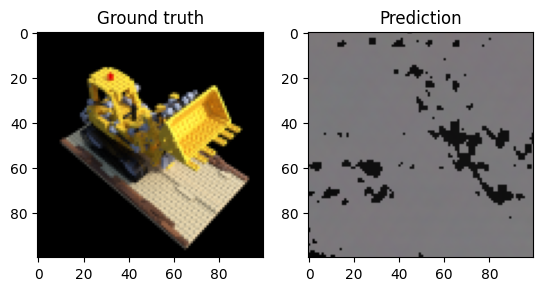

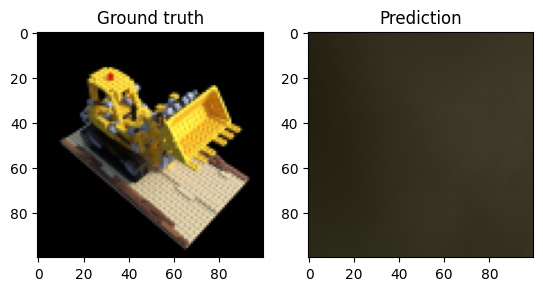

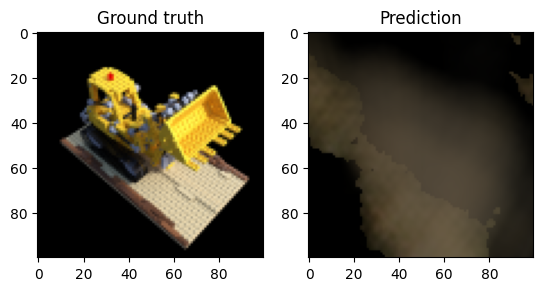

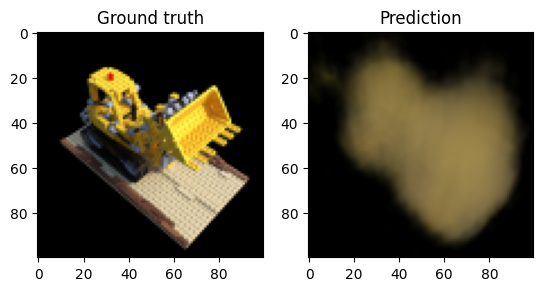

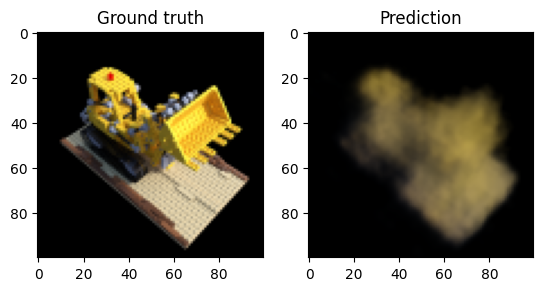

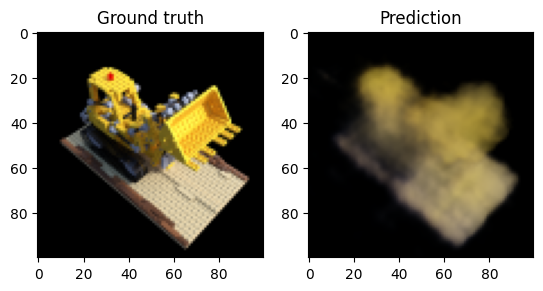

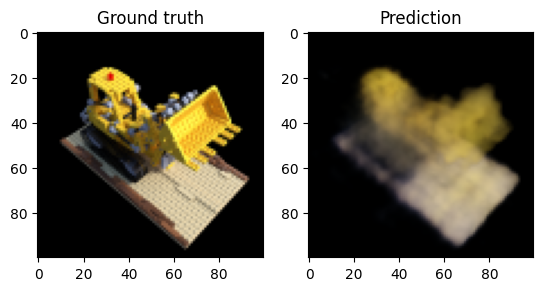

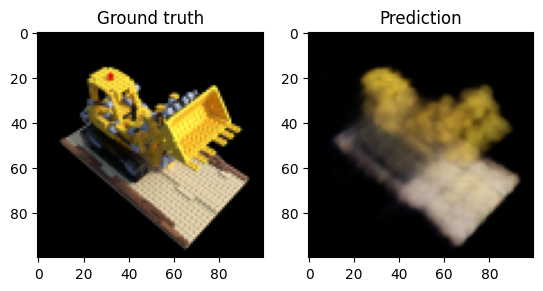

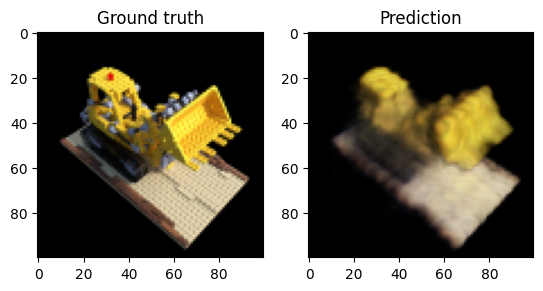

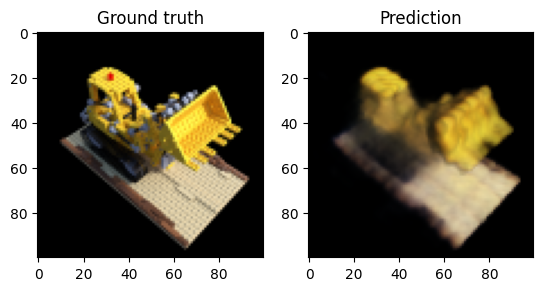

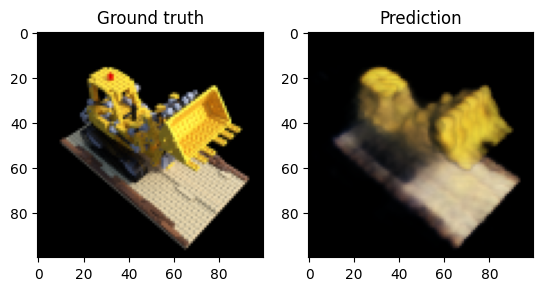

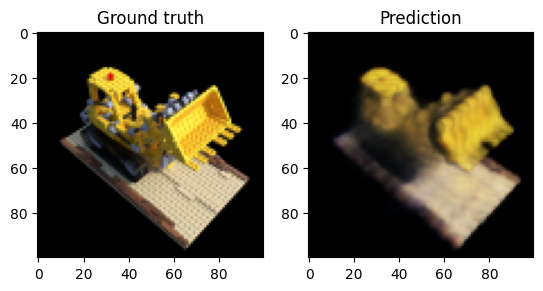

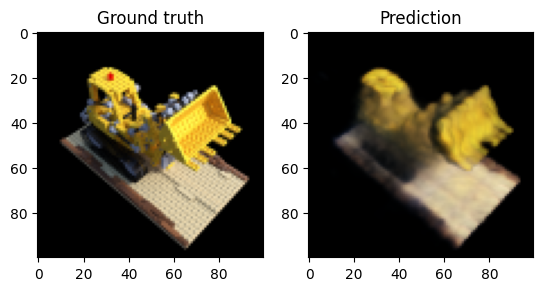

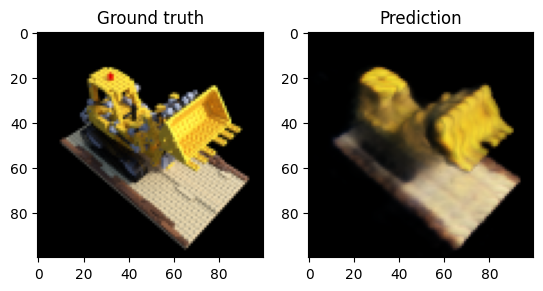

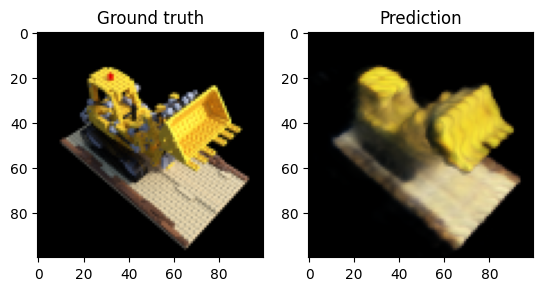

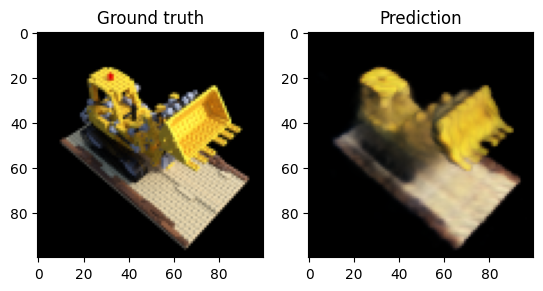

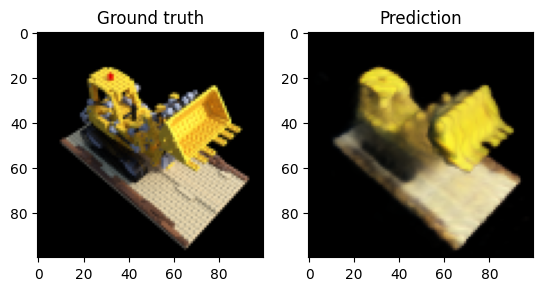

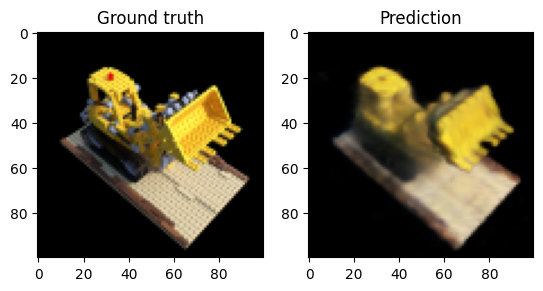

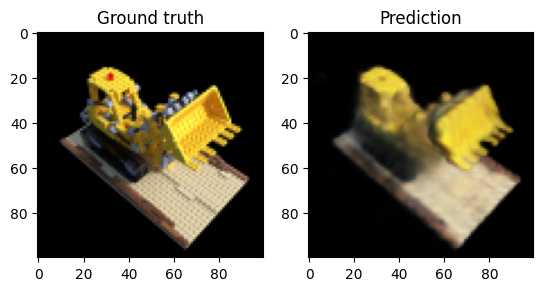

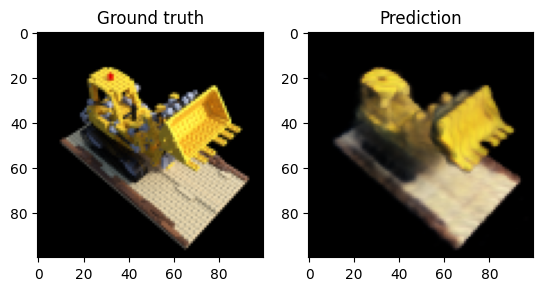

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

emb_dim = 6
num_samples = 64
num_iters = 1000
near, far = 2., 6.
num_images, H, W, _ = imgs.shape

model = NeRF().to(device)
#model = TinyNeRF(39, 256, 8).to(device)
optim = torch.optim.Adam(model.parameters(), 5e-4)
criterion = F.mse_loss

for i in (pbar := tqdm(range(num_iters), ncols=80)):
    
    index = torch.randint(0, num_images, [1])[0]
    img = torch.tensor(imgs[index], device=device)
    pose = torch.tensor(poses[index], device=device)
    ray_origin, ray_dirs = get_rays(H, W, focal, pose)

    pred_img, _, _ = render_rays(
        model, ray_origin, ray_dirs, near, far, num_samples, emb_dim, rand=False)
    loss = criterion(pred_img, img)

    optim.zero_grad()
    loss.backward()
    optim.step()
    pbar.set_postfix({"loss": f"{loss.item():.2e}"})

    if i % 50 == 0:
        with torch.no_grad():
            ray_origin, ray_dirs = get_rays(
                H, W, focal, torch.tensor(test_pose, device=device))
            pred_img, _, _ = render_rays(
                model, ray_origin, ray_dirs, 
                near, far, num_samples, emb_dim, rand=False)

        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(test_img)
        ax[0].set_title("Ground truth")
        ax[1].imshow(pred_img.cpu())
        ax[1].set_title("Prediction")

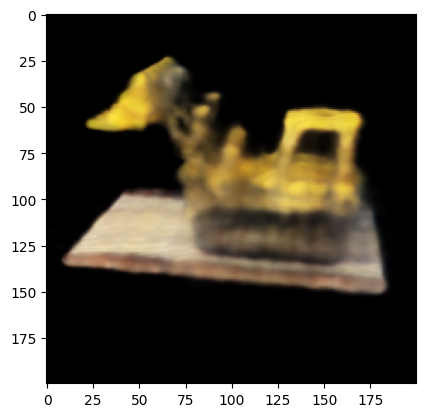

In [30]:
scale = 2
with torch.no_grad():
    ray_origin, ray_dirs = get_rays(
        H*scale, W*scale, focal*scale, torch.tensor(poses[25], device=device))
    pred_img = []
    for ray_dirs_row in ray_dirs:
        pred_row, _, _ = render_rays(
            model, ray_origin, ray_dirs_row, 
            near, far, num_samples, emb_dim, rand=False)
        pred_img.append(pred_row.cpu())
    pred_img = torch.stack(pred_img)
plt.imshow(pred_img.numpy())

In [15]:
#torch.save(model, "tiny_nerf.pt") # around 1.6MB